In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../lib")  # add the library folder to the path I look for modules
import latexify
import networkx as nx
from functools import lru_cache
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu
import itertools
import scipy
import pickle
import random
%matplotlib inline

$$
C_i(\tau)=\frac{1}{N_T-|\tau|} \sum_{t=\tau}^{N_T} (n_i(t)-P_i)(n_i(t-\tau)-P_i)
$$
for $\tau\in \lbrace 0,\dots N_T/2\rbrace$

In [2]:
def load_obj(kin,T,kind):
    name=kind+'_T='+str(T)+'.pkl'
    with open('kin='+str(kin)+'/data/dic-' + name , 'rb') as f:
            return pickle.load(f)

In [3]:
dic = load_obj(5,0.7,'symmetric')
C = dic['C']
N_replics = dic['N_replics']
T = dic['T']
J = dic['J']
kin = dic['kin']
N = dic['N']
try:
    corr_cav = dic['corr_cav']
    P_cav = dic['P_cav']
    P_sim = dic['P_sim']
except KeyError:
    print("don't have cavity")
    pass

In [4]:
#np.count_nonzero(C[:,0]==0)
!ls kin=5/data/

'dic-antisymmetric_T=0.2.pkl'  'dic-asymmetric_T=0.7.pkl'
'dic-antisymmetric_T=0.3.pkl'  'dic-asymmetric_T=1.0.pkl'
'dic-antisymmetric_T=0.5.pkl'   dic-symmetric.pkl
'dic-antisymmetric_T=0.7.pkl'  'dic-symmetric_T=0.2.pkl'
'dic-antisymmetric_T=1.0.pkl'  'dic-symmetric_T=0.3.pkl'
 dic-asymmetric.pkl	       'dic-symmetric_T=0.5.pkl'
'dic-asymmetric_T=0.2.pkl'     'dic-symmetric_T=0.7.pkl'
'dic-asymmetric_T=0.3.pkl'     'dic-symmetric_T=1.0.pkl'
'dic-asymmetric_T=0.5.pkl'


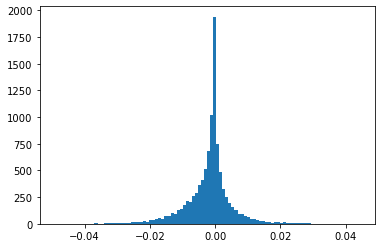

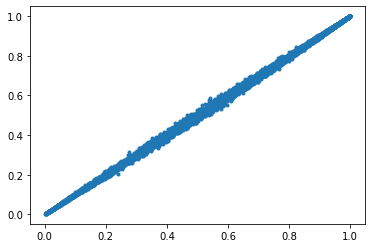

In [5]:
_ = plt.hist(P_sim-P_cav,100)
plt.figure()
plt.plot(P_cav,P_sim,'.')

0.6125137829999999

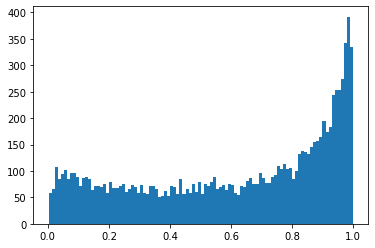

In [6]:
_ = plt.hist(P_sim,100)
np.mean(P_sim)

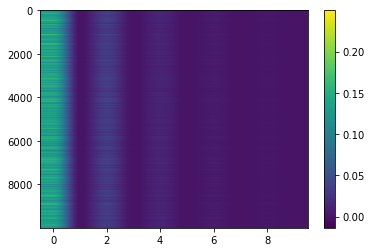

In [7]:
plt.imshow(C[:,:10],aspect = 'auto')
plt.colorbar()

In [10]:
def mapper(kind):
    if kind=='asymmetric':
        return 'uncorrelated'
    else:
        return kind
def load_correlation(gamma,T,kind,**kwargs):
    def load_obj(gamma,T,kind):
        name=kind+'_T='+str(T)+'.pkl'
        with open('gamma='+str(gamma)+'/data/dic-' + name , 'rb') as f:
                return pickle.load(f)
    dic = load_obj(gamma,T,kind)
    C = dic['C']
    N_replics = dic['N_replics']
    T = dic['T']
    J = dic['J']
    gamma = dic['gamma']
    N = dic['N']
    try:
        corr_cav = dic['corr_cav']
        P_cav = dic['P_cav']
        P_sim = dic['P_sim']
    except KeyError:
        print("don't have cavity")
        pass
    c = (C.T/C[:,0]).T[:,:10]
    plt.plot(c.mean(axis = 0 ),label = mapper(kind),**kwargs)
    plt.xlabel('$\\tau$, lag',fontsize = 13)
    plt.ylabel('$\\langle\\rho(\\tau) \\rangle$',fontsize = 13)
    print(N)


don't have cavity
10000
don't have cavity
10000
don't have cavity
10000


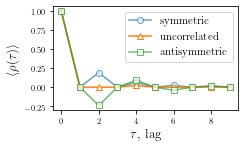

In [12]:
latexify.latexify(columns = 2)
gamma = 3
T = .5
load_correlation(gamma,T,'symmetric', marker  = 'o', mfc = 'w',alpha = 0.7)
load_correlation(gamma,T,'asymmetric',marker = '^', mfc = 'w')
load_correlation(gamma,T,'antisymmetric',marker = 's', mfc = 'w',alpha = 0.7)


plt.legend(fontsize = 11)
plt.tight_layout()
#plt.savefig('correlation_bidirectional.pdf')

Text(0.5, 1.0, 'avg time correlation')

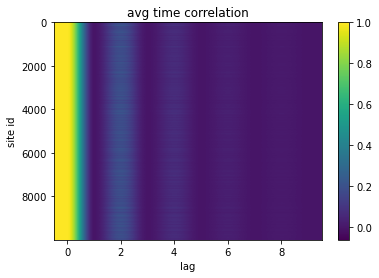

In [8]:
c = (C.T/C[:,0]).T[:,:10]
plt.imshow(c,aspect='auto')
plt.colorbar()
plt.ylabel('site id')
plt.xlabel('lag')
plt.title('avg time correlation')

In [9]:
np.any(C[:,0]>0)

True

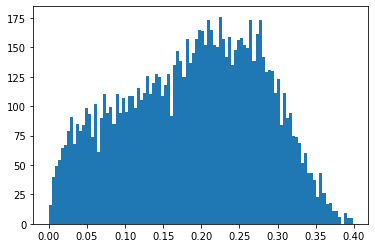

In [10]:
c.shape
_ = plt.hist(c[:,2],100)
#_ = plt.hist(c[:,4],100,alpha = 0.7)

Text(0, 0.5, '$C(\\tau)/C(0)$')

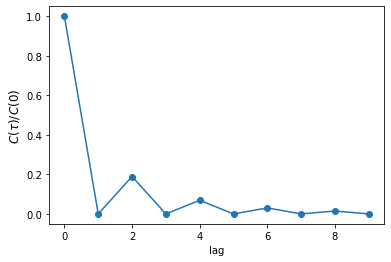

In [11]:
plt.plot(c.mean(axis = 0 ),'-o')
plt.xlabel('lag')
plt.ylabel('$C(\\tau)/C(0)$',fontsize = 12)


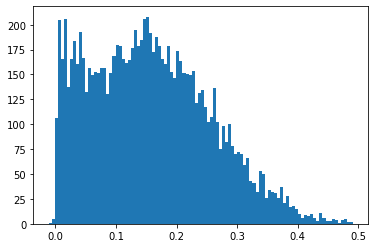

In [29]:
_ = plt.hist((corr_cav-P_cav**2),100)

In [19]:
def equilibrium_prob(J,T,N_iterations = 50):
    def update_equilibrium(P,inter,T):
        numerator = np.prod(1+P*(np.exp(inter/T)-1))#boltzman factor
        return numerator/(numerator+1)#to ensure normalisation
    J_transpose = J.transpose()
    js = J_transpose.tolil().rows
    interaction = J_transpose.tolil().data
    N = J.shape[0]
    P_A =J.copy()
    P_A.data =np.random.rand(J.nnz)#prob of node activation
    row = J.tocoo().row#link to 
    col = J.tocoo().col#link from

    for t in range(N_iterations):
        P_old = P_A.copy()
        for i,l in zip(row,col):
            cond = (np.array(js[i])!=l)#this is for cavity probabilities,# predecessors. of i /{l}
            cav_neigh = np.array(js[i])[cond]   
            P_A[i,l] = update_equilibrium(P_A[cav_neigh,i].toarray().squeeze(),inter = np.array(interaction[i])[cond],T = T)
        improvement = abs(P_A-P_old).max()
        if improvement<1e-4:
            print('ending after ',t,' iterations')
            break
    P_t = np.zeros(N)
    for i in range(N):
        cond = np.array([True]*len(js[i]))
        cav_neigh = np.array(js[i])[cond]   
        P_t[i] = update_equilibrium(P_A[cav_neigh,i].toarray(),inter = np.array(interaction[i])[cond],T = T)
    return P_t
P_eq = equilibrium_prob(J,T,N_iterations = 50)

ending after  9  iterations


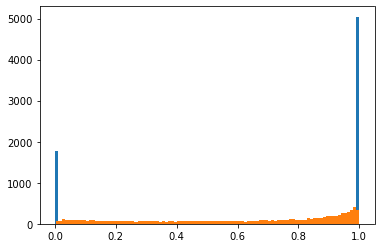

In [20]:
_ = plt.hist(P_eq,100)
_ = plt.hist(P_cav,100)

In [25]:
~np.any((J!=J.transpose()).toarray())#True means matrix is symmetric

True

In [19]:

def generate_degree_seq(gamma, N):
    kseq = np.ceil( 1+np.random.pareto(gamma, N))
    cond = kseq > N
    while any(cond):
        temp_seq = np.ceil( np.random.pareto(gamma, np.count_nonzero(cond)))
        kseq[cond] = temp_seq
        cond = kseq > N
    if sum(kseq)%2==1:
        kseq[-1]+=1
    return np.array(kseq, dtype=int)
def asymmetric_sign(J):
        sign_interaction = np.where(np.random.rand(J.nnz) > 0.5, 1, -1) #assign random sign to links, sign not symmetric
        J.data = np.array(sign_interaction,dtype=np.float32)
        return J
def make_network(N,gamma,kind):
    choises = {'symmetric':symmetric_sign,'antisymmetric':antisymmetric_sign,'asymmetric':asymmetric_sign}
    
    sequence =  generate_degree_seq(gamma,N)
    #make oriented network
    #G = nx.generators.degree_seq.configuration_model([kin]*N)
    G = nx.generators.degree_seq.configuration_model(sequence)
    G = nx.DiGraph(G)
    return J
'''
def make_network(N,kin,kind):
    choises = {'symmetric':symmetric_sign,'antisymmetric':antisymmetric_sign,'asymmetric':asymmetric_sign}
    
    #sequence =  generate_degree_seq(gamma,N)
    #make oriented network
    G = nx.generators.degree_seq.configuration_model([kin]*N)
    #G = nx.generators.degree_seq.directed_configuration_model(sequence, np.random.permutation(sequence))
    #G = nx.DiGraph(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    J = nx.adjacency_matrix(G)
    J = choises[kind](J)#select the symmetry of network interactions
    return J
def symmetric_sign(J):
    row = J.tocoo().row
    col = J.tocoo().col
    cond = row>col
    interaction = np.where(np.random.rand(np.count_nonzero(cond))>.5,1,-1).astype(np.float32)
    A = scipy.sparse.coo_matrix((interaction,(row[cond],col[cond])),shape = (N,N))
    J = (A+A.T).tocsc()
    return J
'''
def antisymmetric_sign(J):
    row = J.tocoo().row
    col = J.tocoo().col
    cond = row>col
    interaction = np.where(np.random.rand(np.count_nonzero(cond))>.5,1,-1).astype(np.float32)
    A = scipy.sparse.coo_matrix((interaction,(row[cond],col[cond])),shape = (N,N))
    J = (A-A.T).tocsc()
    return J

N = 5000
kin = 5
rho = 1
T = 1.
J = make_network(N, 3.5,kind='symmetric')
js = J.transpose().tolil().rows
Ks = np.array([len(neigh) for neigh in js])  # in degree of each gene
min(Ks)

3

In [25]:
all(np.diff(J.tocsr().indptr)==Ks)

True

In [10]:
a = generate_degree_seq(3.5, N)
min(a)

2

In [39]:

def replics_parallel(J, P_init, T, N_replics,N_iterations):
    '''Simulation at fixed T for different replicas
    Initial condition is chosen to be the same as for cavity'''
    '''
    if threads < 0:
        pool = Pool()
    else:
        pool = Pool(int(threads))
    '''
    initial_states = cp.where(cp.random.rand(N_replics,N,dtype=cp.float32) > P_init, 1, 0)
    data = itertools.starmap(dynamics_gpu, itertools.product([J], initial_states, [T], [N_iterations]))
    # for replica in range(N_replic):
    #        data+=[dynamics_light(J,psi_init,T)]
    #pool.close()
    cutoff_correlation = 100
    C_run_mean = np.zeros(N_iterations)
    C = np.zeros((N,N_iterations))
    for trj in data:
        for ind,a in enumerate(trj):
            a = a-cp.mean(a)
            C[ind]+= cp.correlate(a,a,'same').get()
    C_run_mean=C/N_replics
    lag = np.arange(-np.floor(C.shape[1]/2),np.floor(C.shape[1]/2+0.5),dtype = int)
    N_denominator = N_iterations-np.abs(lag) #number of terms in the sum
    return (C_run_mean/N_denominator)[:,(lag>-1)&(lag<cutoff_correlation)]

def dynamics_gpu(J, n, T,N_iterations):
    if not (type(J) is csr_gpu):
        #print('Coupling matrix should be of type'+str(csr_gpu)+', I try to convert')
        J = csr_gpu(J)
    #local_state = cp.random.seed(seed)
    N1 = J.shape[0]
    N_therm = 100
    t = 0
    while t < N_therm:
        z = cp.random.logistic(0, T , (1, N1))
        # z=numpy.random.normal(0,2*T,(1,N1))
        a = n * J - z
        n = cp.where(a > 0, 1, 0.)[0]
        t += 1
    t = 0
    #m = cp.zeros(N1)
    trj = cp.zeros((N1,N_iterations))
    while t < N_iterations:
        z = cp.random.logistic(0, T , (1, N1),dtype=cp.float32)
        # z=numpy.random.normal(0,2*T,(1,N1))
        a = n * J - z
        n = cp.where(a > 0, 1, 0.)[0]
        trj[:,t]= n
        t += 1
    return trj

def dynamics_light_parallel(J, P_init, T, seed,N_iterations):
    local_state = np.random.RandomState(seed)
    N1 = J.shape[0]
    N_therm = 100
    n_start = np.where(np.random.rand(N1) > P_init, 1, 0)
    n = scipy.sparse.csr_matrix(n_start)
    t = 1

    while t < N_therm:
        z = local_state.logistic(0, T, (1, N1))
        # z=numpy.random.normal(0,2*T,(1,N1))
        a = (n * J).toarray() - z
        n = np.where(a > 0, 1, 0)
        n = scipy.sparse.csr_matrix(n)
        t += 1
    t = 0
    #N_iterations =max(int(np.log(1-alpha)/np.log(0.5*(1+np.tanh(1/2/T)))),1000)# number iterations grows at low temperature. See notes

    trj = np.zeros((N1,N_iterations))
    time_average=0
    while t < N_iterations:
        z = local_state.logistic(0, T , (1, N1))
        # z=numpy.random.normal(0,2*T,(1,N1))
        a = (n * J).toarray() - z
        n = np.squeeze(np.where(a > 0, 1, 0))
        trj[:,t]= n
        n = scipy.sparse.csr_matrix(n)
        t += 1
    return trj

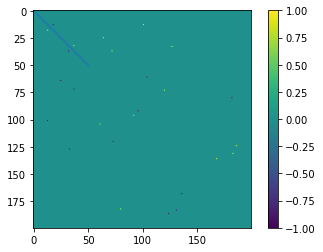

In [91]:
plt.imshow(J.toarray()[300:500,300:500])
plt.plot([0,50],[0,50])
plt.colorbar()

Text(0.5, 1.0, 'avg time correlation')

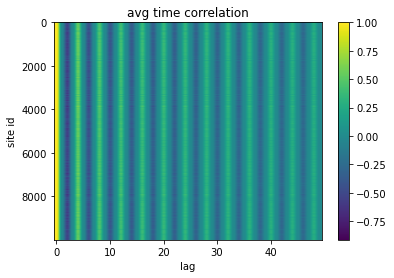

In [92]:
c = (C.T/C[:,0]).T[:,:50]
plt.imshow(c,aspect='auto')
plt.colorbar()
plt.ylabel('site id')
plt.xlabel('lag')
plt.title('avg time correlation')

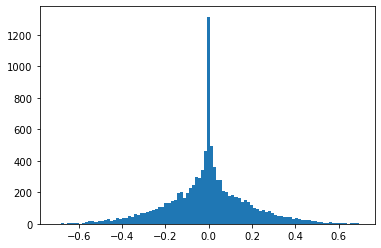

In [53]:
c.shape
_ = plt.hist(c[:,2],100)
#_ = plt.hist(c[:,8],100,alpha = 0.7)

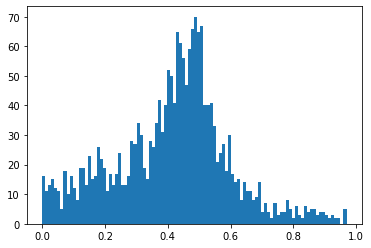

In [120]:
_ = plt.hist(trj.mean(axis = 1).get(),100)

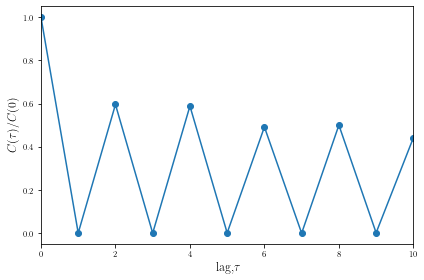

In [136]:
lag = np.arange(-np.floor(len(C)/2),np.floor(len(C)/2+0.5),dtype = int)
plt.plot(lag,np.abs(C)/C[lag==0],'-o')
plt.xlim(0,10)
plt.xlabel('lag,$\\tau$',fontsize = 12)
plt.ylabel('$C(\\tau)/C(0)$',fontsize = 12)
#plt.ylim(-0.1,0.1)
#plt.semilogy()
plt.tight_layout()
#plt.savefig('symmetric.pdf')

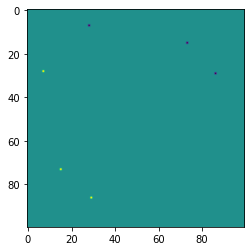

In [47]:
plt.imshow(J.toarray()[:100,:100])

In [65]:
seed = np.random.randint(1, 2 ** 32 - 1)
N_iterations = 10000
trj = dynamics_gpu(J, cp.where(cp.random.rand(N)>0.5,1,0), T,N_iterations)
#trj = dynamics_light_parallel(J, [0.5]*N, T, seed,N_iterations)
#P = cp.mean(trj,axis = 1).get()

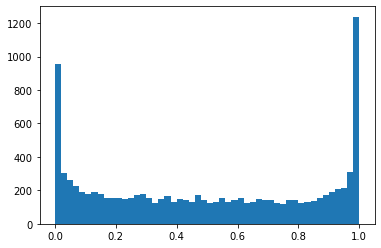

In [41]:
_ = plt.hist(trj.mean(axis =1).get(),50)

In [66]:
C = cp.zeros((N,N_iterations))
for ind,a in enumerate(trj):
    a = a-cp.mean(a)
    C[ind]= cp.correlate(a,a,'same')
lag = np.arange(-np.floor(C.shape[1]/2),np.floor(C.shape[1]/2+0.5),dtype = int)

(10000, 10000)


<ipython-input-67-0c813acbbd9b>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((c.T/c[:,0]).T,aspect='auto')


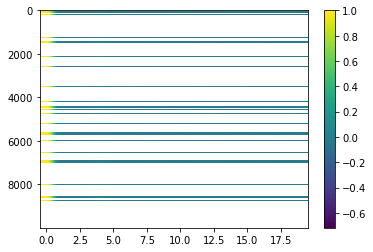

In [67]:
print(C.shape)
N_denominator = (C.shape[1])-np.abs(lag) #number of terms in the sum
c = (C.get()/N_denominator)[:,(lag>-1)&(lag<20)]
plt.imshow((c.T/c[:,0]).T,aspect='auto')
plt.colorbar()
#plt.imshow?

In [60]:
C.get()

array([[ -3.125     ,  -1.117775  ,  -4.11055   , ...,  -3.188325  ,
         -4.11055   ,  -1.117775  ],
       [  9.7392    ,   5.83505216,   1.93090432, ...,  14.02675648,
          1.93090432,   5.83505216],
       [ -0.72405   ,  -7.71750519,   4.28903962, ...,   3.21468443,
          4.28903962,  -7.71750519],
       ...,
       [  8.6088    , -17.62512176,   5.14095648, ...,  43.53383472,
          5.14095648, -17.62512176],
       [ -2.45805   ,  -9.30835839, -15.54556678, ...,  35.21722483,
        -15.54556678,  -9.30835839],
       [-15.71605   ,  -0.89640679,  19.15933642, ...,   0.21507963,
         19.15933642,  -0.89640679]])

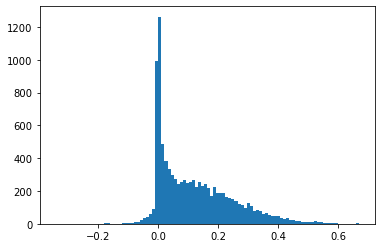

In [52]:
_ = plt.hist(corr_cav-P_cav**2,100)

In [18]:
(C/N_denominator)[:,(lag>-1)&(lag<20)].get()

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.99750000e-04, -2.50050005e-07,  9.97699040e-05, ...,
        -2.50851447e-07, -2.50901623e-07, -2.50951808e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

(0.0, 10.0)

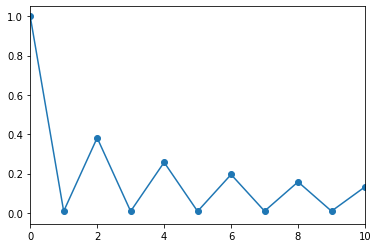

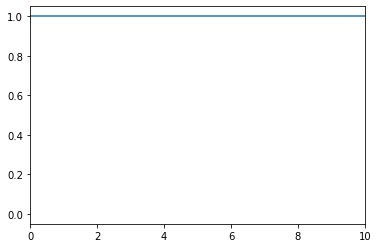

In [57]:
C_mean = cp.mean(C,axis =0).get()
lag = np.arange(-np.floor(len(C_mean)/2),np.floor(len(C_mean)/2+0.5),dtype = int)
N_denominator = len(C_mean)-np.abs(lag) #number of terms in the sum
plt.plot(lag,C_mean/N_denominator/(C_mean[lag == 0]/N_denominator[lag ==0]),'-o')
#plt.plot(lag[::2],(C_mean/N_denominator/(C_mean[lag == 0]/N_denominator[lag ==0]))[::2],'-o',label = 'even')
plt.xlim(0,10)
#plt.semilogy()
plt.figure()
plt.plot(lag,C_mean>0)
plt.xlim(0,10)

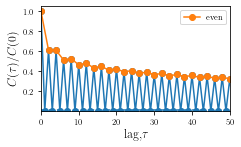

In [106]:
latexify.latexify(columns=2)
C_mean = cp.mean(C,axis =0).get()
lag = np.arange(-np.floor(len(C_mean)/2),np.floor(len(C_mean)/2+0.5),dtype = int)
N_denominator = len(C_mean)-np.abs(lag) #number of terms in the sum
plt.plot(lag,np.abs(C_mean)/N_denominator/(C_mean[lag == 0]/N_denominator[lag ==0]),'-o')
plt.plot(lag[::2],(np.abs(C_mean)/N_denominator/(C_mean[lag == 0]/N_denominator[lag ==0]))[::2],'-o',label = 'even')
plt.xlabel('lag,$\\tau$',fontsize = 12)
plt.ylabel('$C(\\tau)/C(0)$',fontsize = 12)
plt.xlim(0,50)
#plt.semilogy()
plt.legend()
plt.ylim(1e-5,)
plt.tight_layout()
plt.axhline(1/np.sqrt(N),ls = '--')
#plt.savefig('time_correlation.pdf')


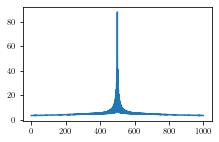

In [13]:
plt.plot(cp.std(C,axis =0).get())

(0.0, 20.0)

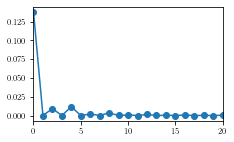

In [66]:
plt.plot(lag,np.abs(C_mean)/N_denominator,'-o')
plt.xlim(0,20)

cavity

In [73]:

def make_epsilon(J):
    N = J.shape[0]
    row = J.tocoo().row
    col = J.tocoo().col
    bi_link = set(zip(row,col))&set(zip(col,row))#set of bidirectional link
    if len(bi_link)==0:
        return scipy.sparse.coo_matrix((N,N))
    a,b = zip(*bi_link)
    return scipy.sparse.coo_matrix((np.ones(len(a),dtype=bool),(np.array(a),np.array(b))),shape = (N,N)).tocsc()

def cavity(P,inter,T,theta):
    @lru_cache(maxsize=None)
    def recursion(bias, l):
        if (l == K):
            bias = (bias + theta) #/ np.sqrt(avg_degree)
            return np.tanh(bias / 2 / T)

        include = P[l] * recursion(bias + inter[l], l + 1)  # include node l with prob. P[j[l]]
        exclude = (1 - P[l]) * recursion(bias, l + 1)  # ignore node l
        return include + exclude
    bias = 0
    K = len(inter)
    P_new = 0.5 + 0.5 * recursion(bias, 0)
    recursion.cache_clear()
    return P_new

def cavity_iteration(J,T,max_iter = 10):
    def probability_upd(i,cond,theta,P_t_2,P_A,P_B):
        cav_neigh = np.array(js[i])[cond]

        A = cavity(P_A[cav_neigh,i].toarray(),inter = np.array(interaction[i])[cond],T = T,theta=theta)
        P_B_temp = np.where(epsilon[cav_neigh,i].toarray(),P_B[cav_neigh,i].toarray(),P_A[cav_neigh,i].toarray())
        #selects either P_A[j,i] or P_B[j,i] depending on epsilon[j,i]=1
        B = cavity(P_B_temp,inter = np.array(interaction[i])[cond],T = T,theta=theta)
        return (1-P_t_2[i])*A+P_t_2[i]*B
    J_transpose = J.transpose()


    #create network properties
    epsilon = make_epsilon(J)
    js = J_transpose.tolil().rows
    interaction = J_transpose.tolil().data
    #R = epsilon.multiply(J_transpose)
    row = J.tocoo().row#link to 
    col = J.tocoo().col#link from
    #data= J_transpose.tocoo().data#interaction strenght from col to row
    Ks = np.array([len(neigh) for neigh in js])  # in degree of each gene
    avg_degree = np.mean(Ks)

    print('fraction of symmetric links over total:\n',len(epsilon.data)/len(J.data))

    trj = [] 
    P_A =J.copy()
    P_B= J.copy()
    P_A.data =np.ones(J.nnz)#np.random.rand(J.nnz)#prob of node activation
    P_B.data =np.ones(J.nnz)#np.random.rand(J.nnz)
    P_t_1 = np.random.rand(J.shape[0])#P^{t-1}
    P_t_2 = np.random.rand(J.shape[0])#P^{t-2}
    P_t = np.zeros(J.shape[0])
    P_A_new = P_A.copy()
    P_B_new = P_B.copy()
    #print(len(list(zip(row,col))))
    for t in range(max_iter):
        # here it is a time step of marginal and cavity
        for i in range(J.shape[0]):
            cond = np.array([True]*len(js[i]))#this is for non-cavity probabilities, predecessors. of i 
            P_t[i] = probability_upd(i,cond,0,P_t_2,P_A,P_B)

        for i,l in zip(row,col):

            cond = (np.array(js[i])!=l)#this is for cavity probabilities,# predecessors. of i /{l}
            P_A_new[i,l] = probability_upd(i,cond,0,P_t_2,P_A,P_B)
            theta = J[l,i]*epsilon[i,l]
            P_B_new[i,l] = probability_upd(i,cond,theta,P_t_2,P_A,P_B)# even if P_B depends on P_A, the index we care about different entries
            
        P_t_2 = P_t_1.copy()#progress time
        P_t_1 = P_t.copy()
        P_A = P_A_new.copy()
        P_B = P_B_new.copy()        
    return P_A,P_B,P_t

In [85]:
%time P_A,P_B,P_t = cavity_iteration(J,T,max_iter = 10)

fraction of symmetric links over total:
 1.0
CPU times: user 20min 18s, sys: 96 ms, total: 20min 18s
Wall time: 20min 19s


In [86]:
theta = 0
epsilon = make_epsilon(J)
J_transpose = J.transpose()
js = J_transpose.tolil().rows
interaction = J_transpose.tolil().data
corr_cav = np.zeros(N)
for i in range(N):
    cav_neigh = np.array(js[i])
    P_B_temp = np.where(epsilon[cav_neigh,i].toarray(),P_B[cav_neigh,i].toarray(),P_A[cav_neigh,i].toarray())
    corr_cav[i]= cavity(P_B_temp,inter = np.array(interaction[i]),T = T,theta=theta)

-0.026265562266215813

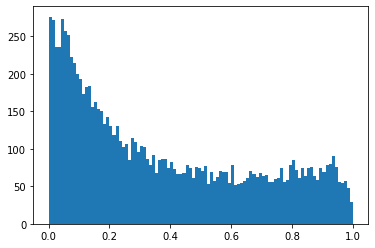

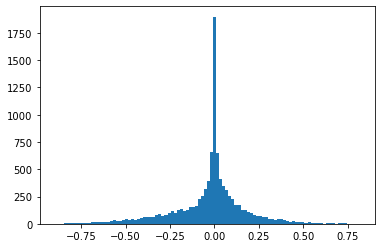

In [97]:
_ = plt.hist(P_t,100)
plt.figure()
_ = plt.hist(corr_cav-P_t**2,100)
np.mean(corr_cav-P_t**2)

Time correlation between states of direct neighbours

In [67]:
G =nx.from_scipy_sparse_matrix(J,create_using=nx.DiGraph())
i,j = zip(*np.sort(G.edges(),axis = 1))

In [68]:
#spin = 2*trj-1
C2 = np.zeros((len(i),N_iterations))
for ind,(a,b) in enumerate(zip(trj[np.array(i)],trj[np.array(j)])):
    a = a-np.mean(a)
    b = b-np.mean(b)
    C2[ind]= np.correlate(a,b,'same')


In [38]:


len(np.mean(C2,axis = 1))

1999

In [ ]:
C2_mean = np.mean((C2.T/np.sqrt(C[np.array(i),lag ==0]*C[np.array(j),lag ==0])),axis =0)
lag = np.arange(-np.floor(len(C2)/2),np.floor(len(C2)/2+0.5),dtype = int)
N_denominator = len(C2)-np.abs(lag) #number of terms in the sum
plt.plot(lag,C2,'-o')
plt.xlabel('lag,$\\tau$')
plt.ylabel('$\\langle C_{ij}(\\tau)\\rangle/C(0)$')
#plt.xlim(-20,20)


<ipython-input-69-1538edd0c18e>:1: RuntimeWarning: invalid value encountered in true_divide
  C2_mean = np.mean((C2.T/np.sqrt(C[np.array(i),lag ==0]*C[np.array(j),lag ==0])),axis =0)


Text(0, 0.5, '$\\langle C_{ij}(\\tau)\\rangle/C(0)$')

In [34]:
x = np.arange(6)
y = np.arange(4,10)
print(np.correlate(x,y,'same'),np.correlate(x,y))
sum(x[1:]*y[:-1])

[ 26  50  80 115 100  82] [115]


100

In [35]:
x[1:],x[:-1]

(array([1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4]))

In [179]:
len(x)-np.abs(np.arange(-np.floor(len(x)/2),np.floor(len(x)/2+0.5),dtype = int))

array([3, 4, 5, 4, 3])

In [180]:
np.abs(np.arange(-np.floor(len(x)/2),np.floor(len(x)/2+0.5),dtype = int))

array([2, 1, 0, 1, 2])

In [117]:
initial_states = cp.where(cp.random.rand(N_replics,N,dtype=cp.float32) > 0.5, 1, 0)
data = itertools.starmap(dynamics_gpu, itertools.product([J], initial_states, [T], [N_iterations]))

In [121]:
a = next(data)

In [124]:
np.mean(a,axis = 1)

array([0.999 , 0.6096, 0.0183, ..., 0.9926, 0.7885, 0.9606])